In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from adjustText import adjust_text
from scipy import stats
import os
import glob
import gc
import networkx as nx
import warnings
import pickle
import json
import base64
from tempfile import mkdtemp
from numba import cuda
from new_cc.new_correlation import xi_corr
import torch
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
gc.collect()

20

In [3]:
# 檢查GPU是否夠用
# 如果CUDA偵測不到GPU，conda install cudatoolkit

def verify_cuda():
    try:
        # 檢查 PyTorch CUDA
        print("=== PyTorch CUDA 信息 ===")
        print(f"PyTorch 是否可見 GPU: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"PyTorch GPU 數量: {torch.cuda.device_count()}")
            print(f"當前 GPU: {torch.cuda.get_device_name()}")
        
        # 檢查 Numba CUDA
        print("\n=== Numba CUDA 信息 ===")
        print(f"Numba CUDA 是否可用: {cuda.is_available()}")
        if cuda.is_available():
            print(f"Numba CUDA 設備數量: {len(cuda.list_devices())}")
            for i in range(len(cuda.list_devices())):
                print(f"設備 {i}: {cuda.get_current_device().name}")
    except Exception as e:
        print(f"檢查 CUDA 時出錯: {e}")

verify_cuda()

=== PyTorch CUDA 信息 ===
PyTorch 是否可見 GPU: True
PyTorch GPU 數量: 2
當前 GPU: NVIDIA GeForce RTX 2080 Ti

=== Numba CUDA 信息 ===
Numba CUDA 是否可用: True
Numba CUDA 設備數量: 2
設備 0: b'NVIDIA GeForce RTX 2080 Ti'
設備 1: b'NVIDIA GeForce RTX 2080 Ti'


In [3]:
# 查看測試資料及滯後項
test = pd.read_parquet('/home/h24119013/jane-street-data/test.parquet/date_id=0/part-0.parquet')
test.head()

,row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,0,3.169998,True,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,1,0,0,1,2.165993,True,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,2,0,0,2,3.065550,True,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,3,0,0,3,2.698642,True,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,4,0,0,4,1.803330,True,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0


In [4]:
# 查看測試資料及滯後項
test_lags = pd.read_parquet('/home/h24119013/jane-street-data/lags.parquet/date_id=0/part-0.parquet')
test_lags.head()

,date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,0,-0.442215,-0.322407,0.143594,-0.926890,-0.782236,-0.036595,-1.305746,-0.795677,-0.143724
1,0,0,1,-0.651829,-1.707840,-0.893942,-1.065488,-1.871338,-0.615652,-1.162801,-1.205924,-1.245934
2,0,0,2,-0.656373,-0.264575,-0.892879,-1.511886,-1.033480,-0.378265,-1.574290,-1.863071,-0.027343
3,0,0,3,-0.188186,-0.190970,-0.701490,0.098453,-1.015506,-0.054984,0.329152,-0.965471,0.576635
4,0,0,4,-0.257462,-0.471325,-0.297420,0.074018,-0.324194,-0.597093,0.219856,-0.276356,-0.904790


In [14]:
print(len(test),len(test_lags))

39 39


### 需要重新跑權重喔

In [4]:
# 先將所有訓練資料讀取並合併
train_data = pd.DataFrame()
train_data_list = glob.glob('./train.parquet/**/part-0.parquet', recursive=True)
for file in train_data_list:
    df = pd.read_parquet(file)
    df['partition'] = float(file.split('/')[-2][-1])
    train_data = pd.concat([train_data, df])
    del df
    gc.collect()

# 篩選出feature_names的資料
feature_names = train_data.columns.tolist()[4:-10]

train_data.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition
0,340,0,0,1.902722,-0.523490,-0.131996,0.124154,-0.185518,2.011005,-0.665424,-1.030033,-1.528010,0.261375,11,7,76,-1.169775,-0.299280,-0.477456,NaN,-0.423311,NaN,-1.333162,-1.697360,0.204428,NaN,-0.089592,-0.207202,-0.697006,-0.771086,NaN,NaN,0.791180,-0.361479,-0.114389,NaN,NaN,NaN,-0.175443,-0.080401,1.368903,0.198668,0.045900,NaN,-2.474520,NaN,NaN,-2.898822,NaN,NaN,NaN,0.296719,-0.734900,-0.130546,NaN,-0.928921,NaN,NaN,-2.067725,NaN,-2.501255,1.346438,NaN,-0.946561,-0.337844,0.354287,NaN,NaN,NaN,NaN,NaN,-0.702601,-0.266509,-0.533959,-1.319765,-0.160904,-0.953981,NaN,NaN,0.210584,0.312869,-0.187011,-0.183416,0.251685,0.421458,0.771927,0.071990,1.426416,0.814566,-0.132949,1.183992,0.371725,2.0
1,340,0,1,4.090041,-0.156282,0.289095,0.193019,-0.070085,1.140459,-0.528798,-0.884754,-1.443790,0.220660,11,7,76,-0.837111,0.421702,-0.336571,NaN,-0.530792,NaN,-0.878517,-0.865011,0.834150,NaN,1.584139,1.088018,-0.088035,0.203477,NaN,NaN,1.462279,-0.296079,-0.364353,NaN,NaN,NaN,-0.041622,-0.062732,-0.881672,0.009250,0.163690,NaN,0.819656,NaN,NaN,0.873064,NaN,-1.479233,2.186059,-0.092519,1.206873,0.350423,NaN,1.465106,NaN,NaN,0.999406,NaN,-1.427631,2.658593,NaN,1.788883,0.399241,0.354287,-0.232378,-0.293213,-0.304407,-1.098295,-1.787442,-0.965382,0.135424,-0.344909,-1.035528,1.161382,-0.308803,NaN,NaN,-0.240021,-0.312621,-0.338355,-0.292850,-0.199408,-0.148638,-0.796567,-0.929294,0.055380,-0.585740,-0.891481,0.184394,-0.402399,2.0
2,340,0,2,1.403712,-0.002521,-0.261839,-0.006259,0.041238,1.180197,-1.034970,-0.990703,-1.023218,0.242779,81,2,59,-1.094649,-0.381583,-0.515383,NaN,0.621933,NaN,-1.594152,-2.234390,-1.585274,NaN,-1.111434,-0.880511,-0.615049,-0.929672,NaN,NaN,0.668325,-0.378213,-0.514761,NaN,NaN,NaN,-0.313938,0.633901,2.461723,0.308924,-0.110976,NaN,0.281677,NaN,NaN,1.256042,NaN,NaN,NaN,-0.184656,-4.855862,-0.116942,NaN,-1.394318,NaN,NaN,-2.148139,NaN,-2.872841,0.405369,NaN,-6.387812,-2.851222,0.354287,NaN,NaN,NaN,NaN,NaN,-0.934786,-0.180497,-0.628079,-0.357187,-0.363289,-0.860691,NaN,NaN,3.899125,4.003406,3.078561,2.798186,0.268406,-0.458026,-1.878922,4.185539,0.808422,0.217188,4.563775,0.802501,1.707263,2.0
3,340,0,3,0.904068,0.285563,0.159232,0.158522,-0.564407,1.300828,-0.625577,-0.515945,-0.977850,0.166003,4,3,11,-0.952348,0.035830,-0.638500,NaN,-0.386088,NaN,-1.722304,-1.366947,0.573252,NaN,-1.292146,-1.503999,0.018867,0.922218,NaN,NaN,-1.658296,-0.531493,-0.404090,NaN,NaN,NaN,-1.022619,0.139672,2.735279,-0.045127,-0.041756,NaN,0.784627,NaN,NaN,0.986058,NaN,NaN,NaN,1.101612,4.273861,2.538638,NaN,0.575681,NaN,NaN,0.415187,NaN,-1.794518,2.370505,NaN,1.061412,0.518248,0.354287,NaN,NaN,NaN,NaN,NaN,-0.845495,-0.389196,-0.486743,-0.940938,0.477874,-0.355728,NaN,NaN,-0.242512,-0.122299,-1.381474,-1.028829,0.960588,0.610246,2.921769,-0.170994,1.217213,1.891398,-1.207013,0.868314,0.723984,2.0
4,340,0,7,1.308947,0.321869,0.211620,-0.195385,-0.358547,1.595914,-0.820045,-0.784618,-0.980539,0.141644,11,7,76,-0.616368,0.068370,-0.5284

In [5]:
train_data[['symbol_id','time_id']].value_counts()

symbol_id  time_id
19         843        1684
           842        1684
           844        1684
           824        1684
           823        1684
           822        1684
           821        1684
           820        1684
           819        1684
           818        1684
           817        1684
           816        1684
           815        1684
           814        1684
           813        1684
           812        1684
           11         1684
           10         1684
           9          1684
           8          1684
           7          1684
           6          1684
           5          1684
           4          1684
           3          1684
           2          1684
           1          1684
           0          1684
           27         1684
           26         1684
           25         1684
           808        1684
           807        1684
           806        1684
           805        1684
           804        1684
         

In [4]:
# 考量實用性，若想將遺失值設為0，需要先檢查0有多少個
value0 = [len(train_data[train_data[feature] == 0]) for feature in feature_names]
print(value0)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
# 可以看到遺失值最多占20%
train_data.isna().sum()

date_id              0
time_id              0
symbol_id            0
weight               0
feature_00     3182052
feature_01     3182052
feature_02     3182052
feature_03     3182052
feature_04     3182052
feature_05           0
feature_06           0
feature_07           0
feature_08      300247
feature_09           0
feature_10           0
feature_11           0
feature_12           0
feature_13           0
feature_14           0
feature_15     1209299
feature_16         261
feature_17      201838
feature_18         226
feature_19         226
feature_20           0
feature_21     8435985
feature_22           0
feature_23           0
feature_24           0
feature_25           0
feature_26     8435985
feature_27     8435985
feature_28           0
feature_29           0
feature_30           0
feature_31     8435985
feature_32      478457
feature_33      478457
feature_34           0
feature_35           0
feature_36           0
feature_37         849
feature_38           0
feature_39 

In [4]:
# 將遺失值設為0
train_data.replace(np.nan, 0, inplace=True)

In [5]:
gc.collect()

0

In [7]:
train_data['date_id'].nunique()

1699

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47127338 entries, 0 to 6203911
Data columns (total 93 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32  fe

### EDA

In [5]:
# 計算Range & 99% IQR & IQR，比較離散程度
iqr_position = [[],[],[]]            # Range & 99% IQR & IQR
for feature in feature_names:
    iqr_position[0].append(train_data[feature].max() - train_data[feature].min())
    iqr_position[1].append(train_data[feature].quantile(0.995) - train_data[feature].quantile(0.005))
    iqr_position[2].append(train_data[feature].quantile(0.75) - train_data[feature].quantile(0.25))

In [6]:
max_range = max(iqr_position[0])
max_99_iqr = max(iqr_position[1])
max_iqr = max(iqr_position[2])
min_range = min(iqr_position[0])
min_99_iqr = min(iqr_position[1])
min_iqr = min(iqr_position[2])
print('max range:', max_range, 'max 99% IQR:', max_99_iqr, 'max IQR:', max_iqr)
print('min range:', min_range, 'min 99% IQR:', min_99_iqr, 'min IQR:', min_iqr)

max range: 1069.0604 max 99% IQR: 530.0 max IQR: 171.0
min range: 5.8287306 min 99% IQR: 2.0848004519939423 min IQR: 0.22489067539572716


In [7]:
# 繪製Range & IQR的散點圖   minmax_position[[Range],[99% IQR],[IQR]]

def plot_range_iqr(minmax_position):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))    
    ax1.scatter(minmax_position[0], minmax_position[2])
    ax2.scatter(minmax_position[1], minmax_position[2])

    # 加入45度直線
    x = np.logspace(-6, 6, 100)
    ax1.plot(x, x, 'r--', label='45 degree line')
    ax2.plot(x, x, 'r--', label='45 degree line')

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1e-1, 1e4)  # 調整x軸範圍
    ax1.set_ylim(1e-1, 1e4)  # 調整y軸範圍

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim(1e-1, 1e4)  # 調整x軸範圍
    ax2.set_ylim(1e-1, 1e4)  # 調整y軸範圍

    ax1.set_xlabel('Range')
    ax1.set_ylabel('IQR')
    ax1.set_title('Range and IQR of features')

    ax2.set_xlabel('99% IQR')
    ax2.set_ylabel('IQR')
    ax2.set_title('99% IQR and IQR of features')
    plt.show()

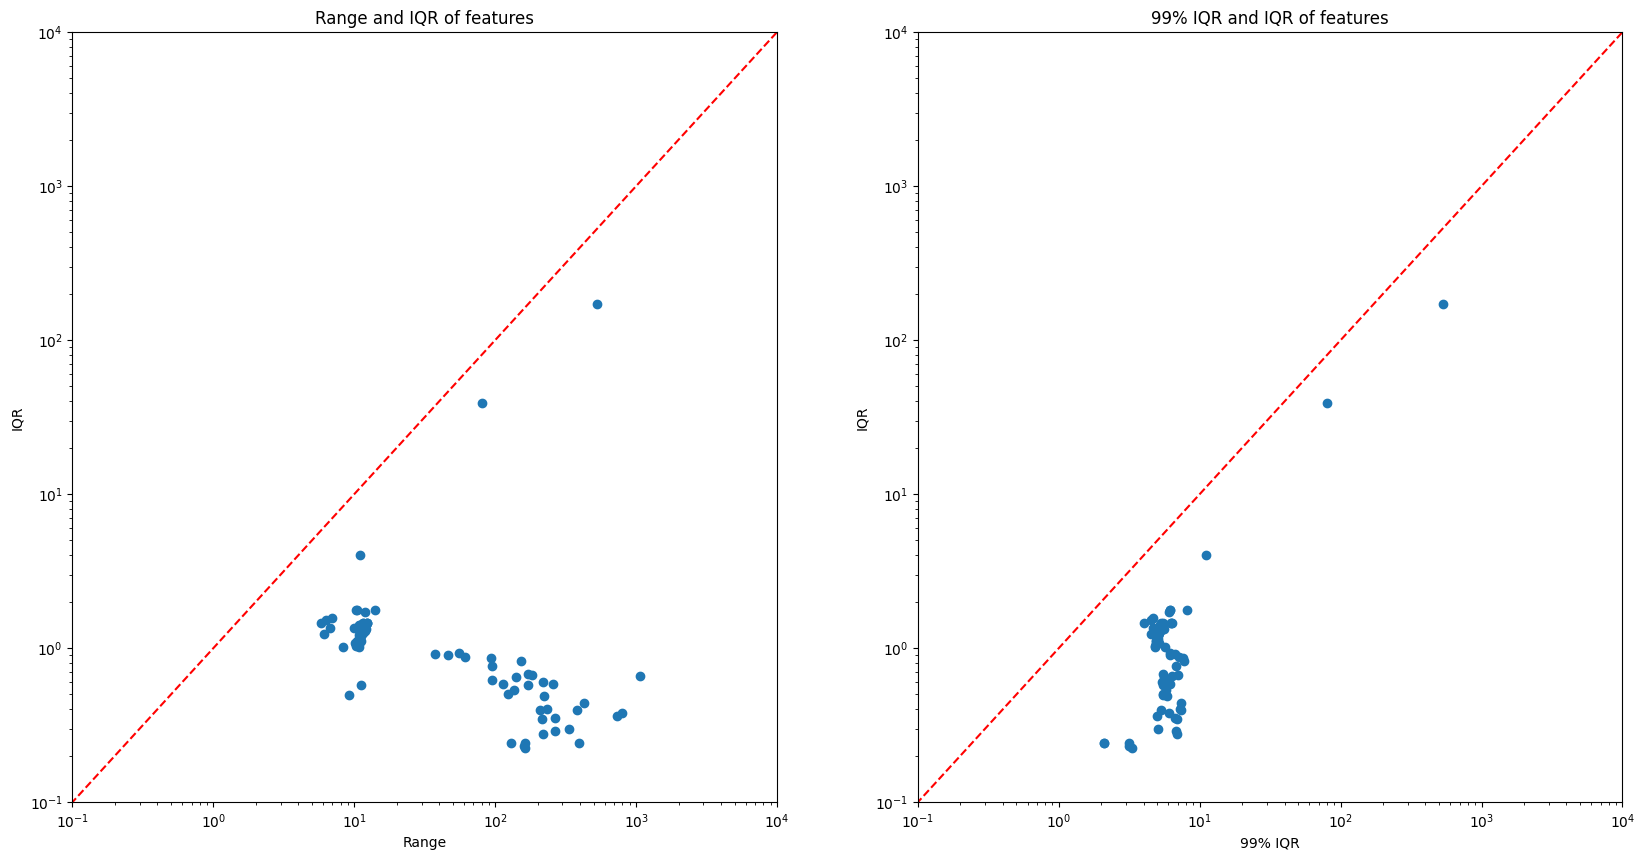

In [9]:
plot_range_iqr(iqr_position)

In [10]:
gc.collect()

29249

In [24]:
# 計算相關係數，但需要先抽樣
# 計算原始數據中每個 partition 的比例
original_ratios = (train_data['partition'].value_counts() / len(train_data)).to_dict()

# 設定目標總抽樣比例為 20%
target_ratio = 0.2

# 根據比例進行抽樣
sample_data = train_data.groupby('partition').apply(
    lambda x: x.sample(frac=target_ratio, random_state=77)  # 設定隨機種子確保結果可重現
)

# 重設索引
sample_data = sample_data.reset_index(drop=True)

# 檢查結果
print('train_data total length:', len(train_data))
print('\n原始數據分布：')
print(train_data['partition'].value_counts(normalize=True))

# 篩選出feature_names的資料
sample_data_feature = sample_data.loc[:, feature_names]


train_data total length: 47127338

原始數據分布：
partition
7.0    0.134435
9.0    0.133141
6.0    0.131641
8.0    0.130286
5.0    0.113484
4.0    0.106583
3.0    0.085233
2.0    0.064440
1.0    0.059504
0.0    0.041254
Name: proportion, dtype: float64


KeyError: "None of [Index(['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04',\n       'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09',\n       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',\n       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',\n       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',\n       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',\n       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',\n       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',\n       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',\n       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',\n       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',\n       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',\n       'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64',\n       'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69',\n       'feature_70', 'feature_71', 'feature_72', 'feature_73', 'feature_74',\n       'feature_75', 'feature_76', 'feature_77', 'feature_78'],\n      dtype='object')] are in the [columns]"

In [8]:
gc.collect()

0

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

def xicor_optimized(X, Y, ties=True):
    np.random.seed(77)
    X = np.asarray(X, dtype=np.float64)  # 确保为 float64
    Y = np.asarray(Y, dtype=np.float64)  # 确保为 float64
    n = len(X)
    order = X.argsort()  # 使用 argsort 确定排序索引
    Y_sorted = Y[order]

    if ties:
        # 使用逐步累加的方式避免内存爆炸
        l = np.zeros(n, dtype=np.int64)
        for i in range(n):
            l[i] = np.sum(Y_sorted >= Y_sorted[i])
        r = l.copy()
        for j in range(n):
            if (r == r[j]).sum() > 1:
                tie_index = (r == r[j])
                num_ties = tie_index.sum()
                r[tie_index] = np.random.choice(
                    r[tie_index] - np.arange(0, num_ties), num_ties, replace=False
                )
        result = 1 - n * np.sum(np.abs(r[1:] - r[:-1])) / (2 * np.sum(l * (n - l)))
    else:
        r = np.zeros(n, dtype=np.int64)
        for i in range(n):
            r[i] = np.sum(Y_sorted >= Y_sorted[i])
        result = 1 - 3 * np.sum(np.abs(r[1:] - r[:-1])) / (n**2 - 1)

    # 确保结果在 [0, 1] 范围内
    return max(0, min(1, result))

def calculate_heatmap(data, num_workers=2, ties=True):
    data = np.asarray(data, dtype=np.float64)  # 确保为 float64
    num_vars = data.shape[1]
    heatmap = np.zeros((num_vars, num_vars), dtype=np.float64)

    def compute_pairwise(args):
        i, j = args
        return i, j, xicor_optimized(data[:, i], data[:, j], ties)

    # 创建所有需要计算的变量对
    pairs = [(i, j) for i in range(num_vars) for j in range(i, num_vars)]

    with Pool(num_workers) as pool:
        results = pool.imap_unordered(compute_pairwise, pairs, chunksize=10)

    # 填充热图矩阵
    for i, j, value in results:
        heatmap[i, j] = value
        heatmap[j, i] = value  # 对称矩阵

    return heatmap

def plot_heatmap(heatmap, labels=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='XiCor')
    if labels:
        plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
        plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.title('XiCor Heatmap')
    plt.tight_layout()
    plt.show()



In [9]:
# 计算 XiCor 热图
data = train_data[['feature_' + format(i, '02d') for i in range(79)]]

heatmap = calculate_heatmap(data, num_workers=4, ties=True)
# 绘制热图
plot_heatmap(heatmap, labels=[f"Var{i+1}" for i in range(79)])

: 

In [ ]:
#corr = np.zeros((len(feature_names), len(feature_names)))
#for i in range(len(feature_names)):
#    for j in tqdm(range(i+1, len(feature_names))):
#        corr[i, j] = xicor(sample_data_feature[feature_names[i]], sample_data_feature[feature_names[j]])
#        corr[j, i] = corr[i, j]

#corr.save('new_corr_matrix.npy')

In [9]:
# 計算相關係數
# 因為有離群值，所以不使用pearson
corr_matrix = sample_data_feature.corr(method='kendall')

In [10]:
# 儲存成npy
# np.save('corr_matrix.npy', corr_matrix)
# 讀取npy
corr_matrix = np.load('corr_matrix.npy')

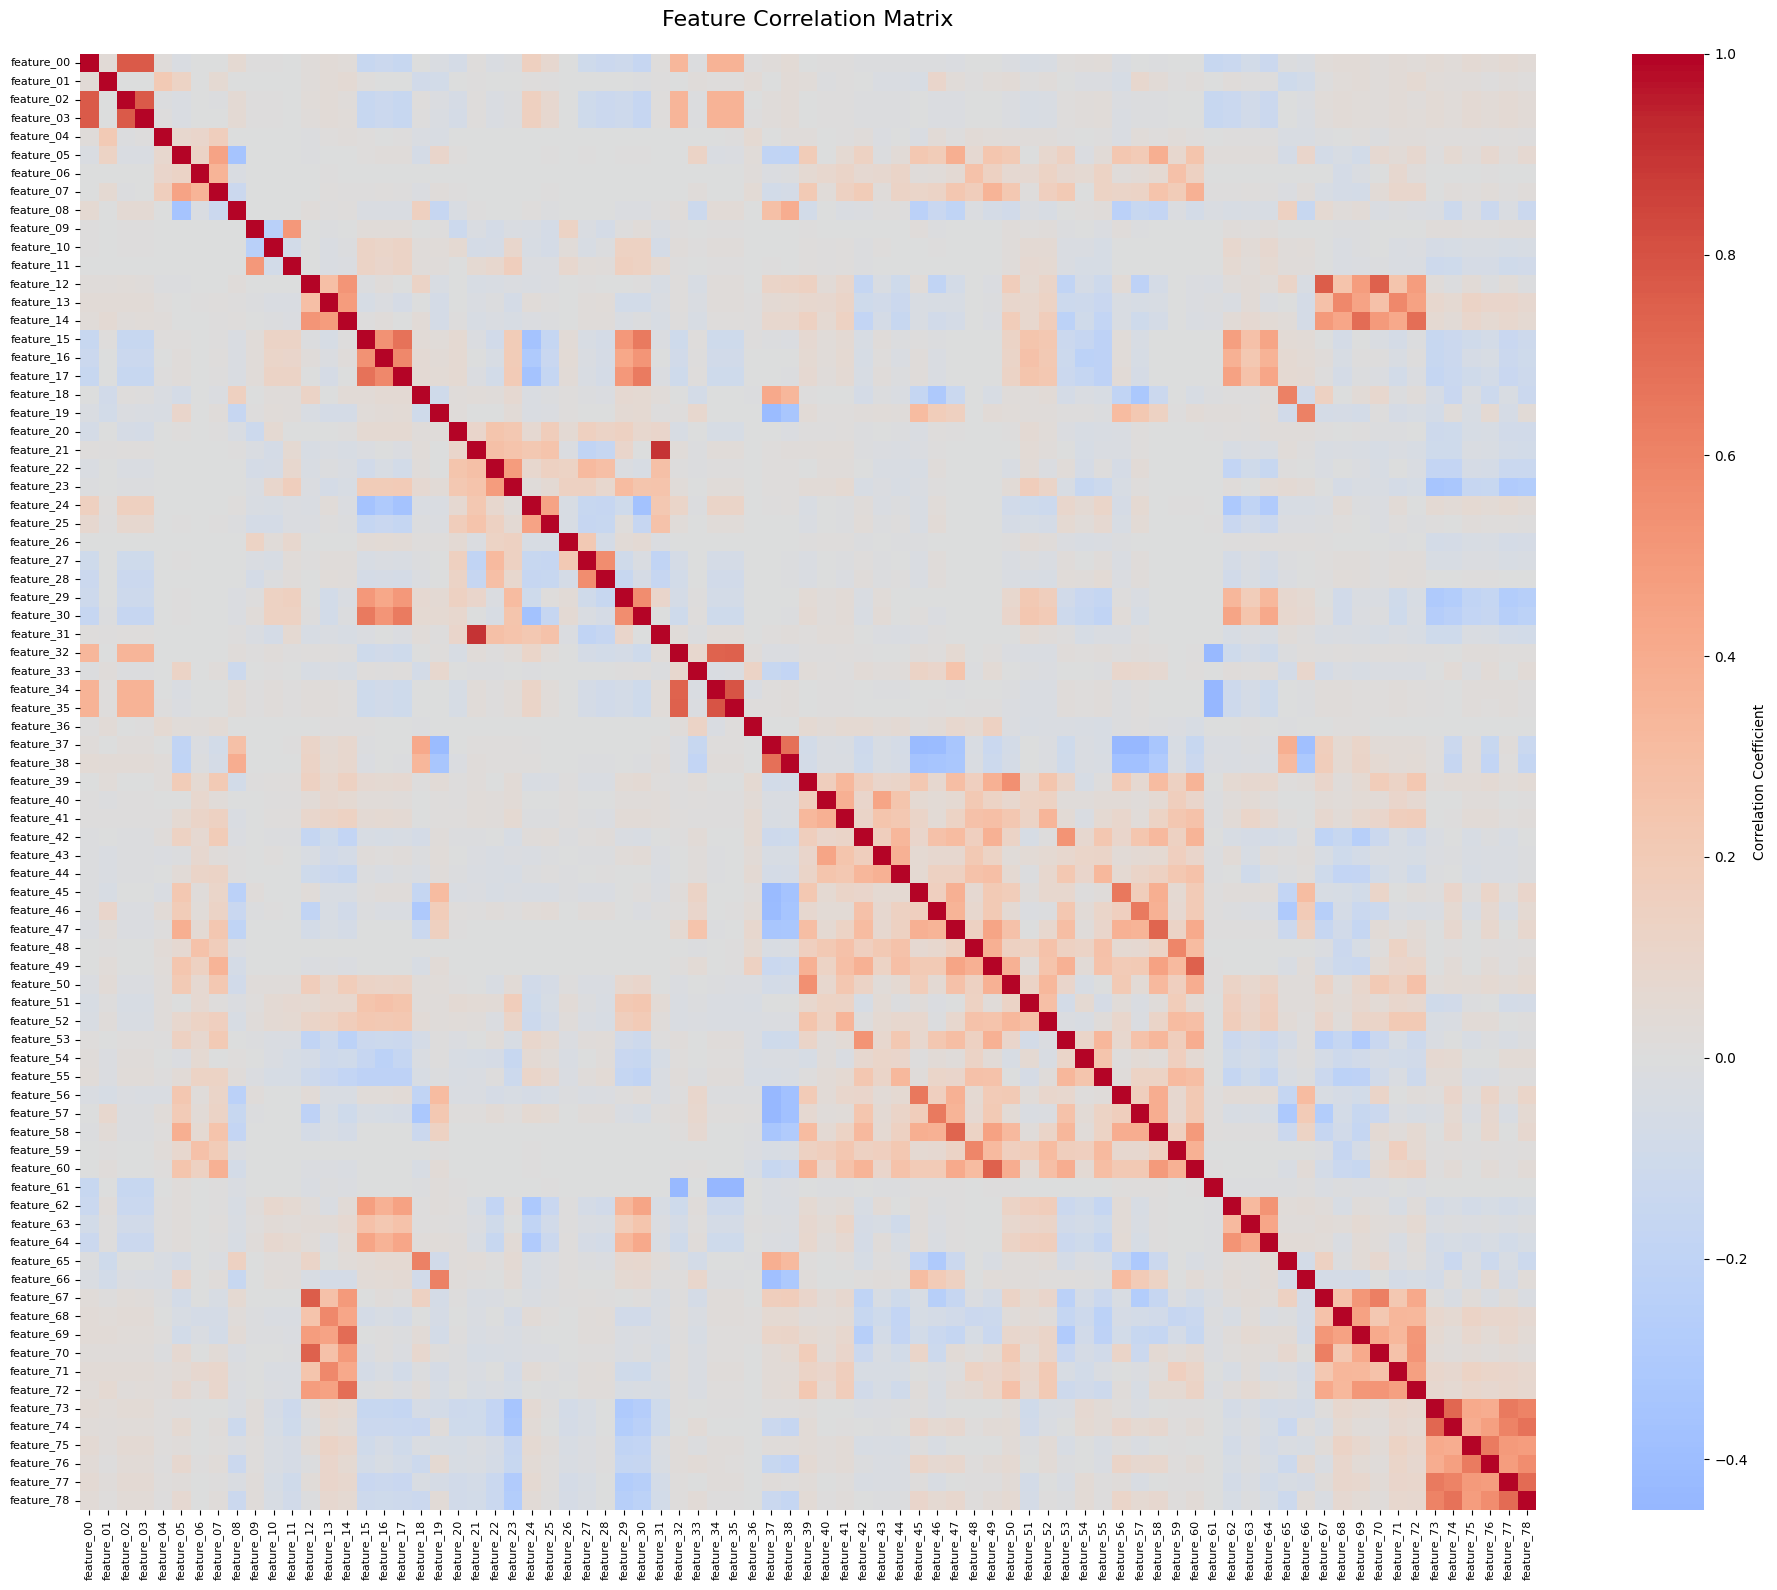

In [11]:
# 繪製相關係數熱力圖
plt.figure(figsize=(20, 16))

# 創建熱力圖
heatmap = sns.heatmap(corr_matrix, 
                      cmap='coolwarm',     
                      center=0,            
                      square=True,         
                      annot=False,         
                      fmt='.2f',
                      xticklabels=True,    # 確保顯示x軸標籤
                      yticklabels=True,    # 確保顯示y軸標籤
                      cbar_kws={'label': 'Correlation Coefficient'})

# 設置標籤
heatmap.set_xticklabels(feature_names, rotation=90, fontsize=8)
heatmap.set_yticklabels(feature_names, rotation=0, fontsize=8)

# 添加標題
plt.title('Feature Correlation Matrix', pad=20, fontsize=16)

# 調整布局以確保所有標籤都可見
plt.tight_layout()

plt.show()


In [12]:
# 根據維基百科，相關係數大於0.5則認為是強相關，大於0.3則認為是中度相關，大於0.1則認為是弱相關

# 如果你想要找出最強的相關性：
# 獲取上三角矩陣的相關係數（排除對角線）
upper_tri = np.triu(corr_matrix, k=1)
# 找出最強的相關性（正相關和負相關）
strongest_corr = []
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        if abs(upper_tri[i,j]) > 0.5:  # 可以調整閾值
            strongest_corr.append((int(feature_names[i][-2:]), 
                                 int(feature_names[j][-2:]), 
                                 upper_tri[i,j]))

# 按照相關係數的絕對值排序
strongest_corr.sort(key=lambda x: abs(x[2]), reverse=True)

# 打印最強的相關性
print("\n最強的特徵相關性：")
for feat1, feat2, corr in strongest_corr[:10]:  # 顯示前10個
    print(f"{feat1} vs {feat2}: {corr:.3f}")


最強的特徵相關性：
21 vs 31: 0.901
34 vs 35: 0.785
2 vs 3: 0.771
0 vs 3: 0.768
0 vs 2: 0.765
12 vs 67: 0.762
12 vs 70: 0.749
49 vs 60: 0.743
32 vs 35: 0.743
32 vs 34: 0.737


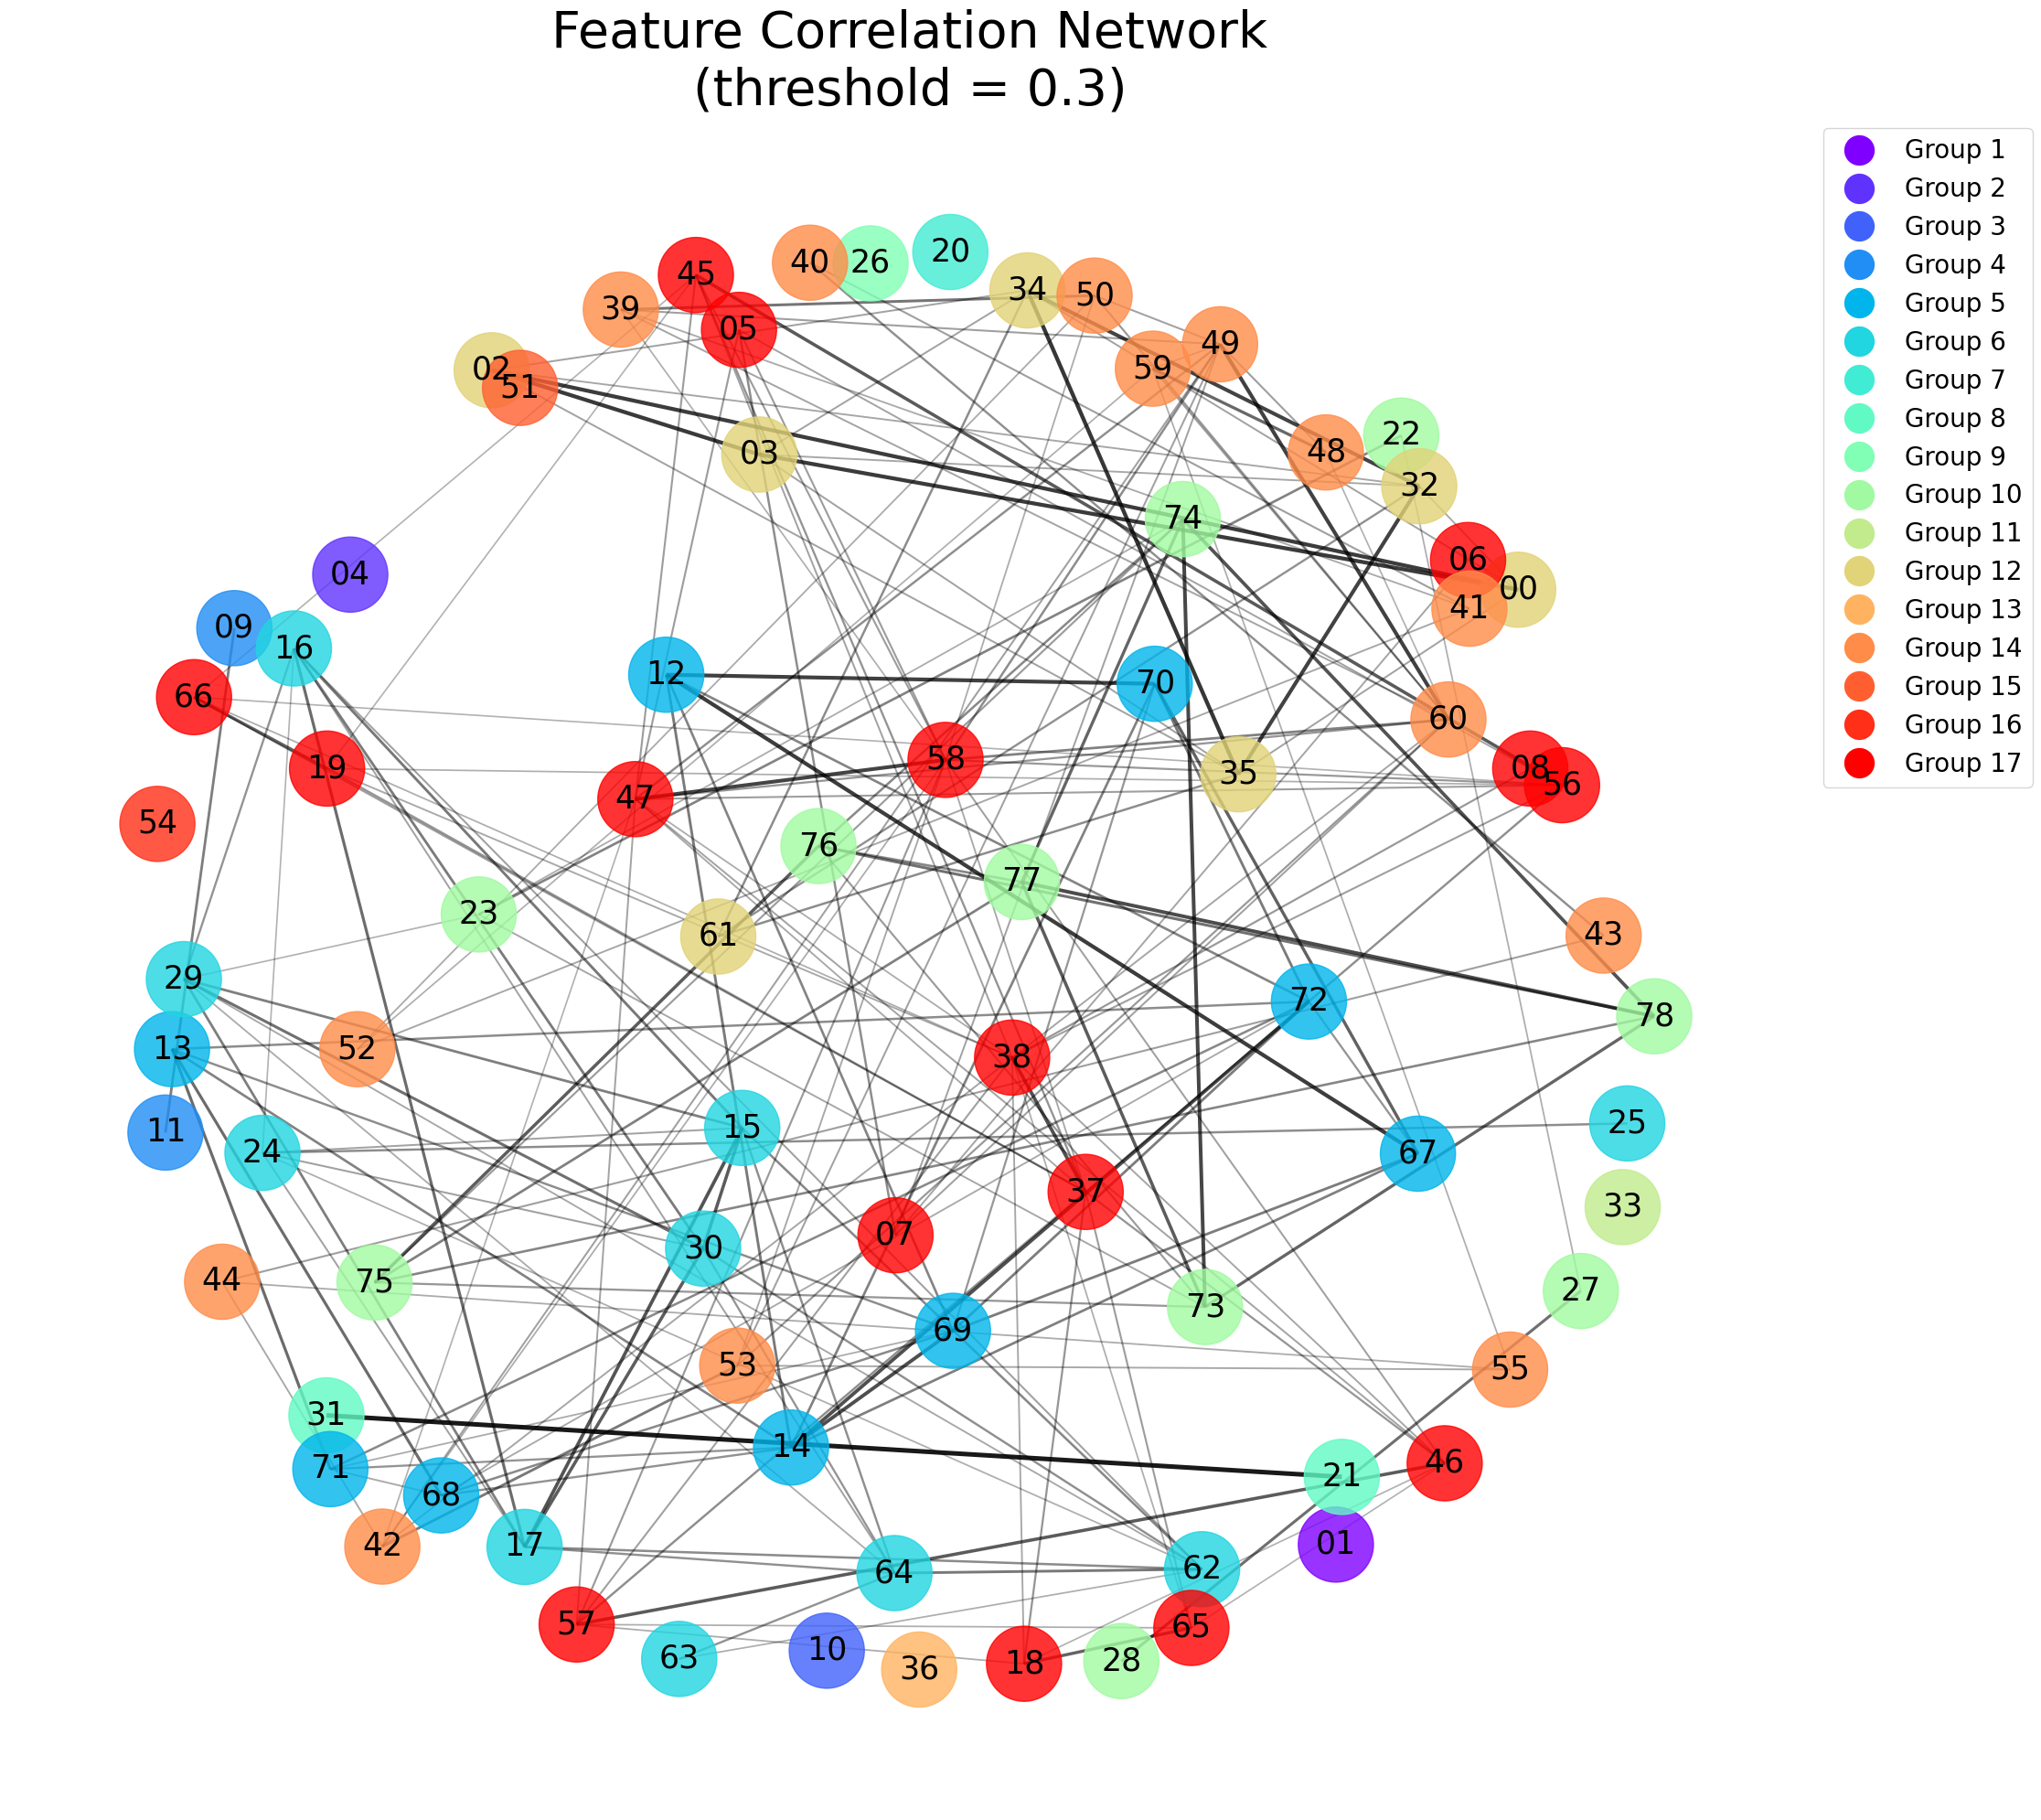


各組成員：
Group 1: ['01']
Group 2: ['04']
Group 3: ['10']
Group 4: ['09', '11']
Group 5: ['12', '13', '14', '67', '68', '69', '70', '71', '72']
Group 6: ['15', '16', '17', '24', '25', '29', '30', '62', '63', '64']
Group 7: ['20']
Group 8: ['21', '31']
Group 9: ['26']
Group 10: ['22', '23', '27', '28', '73', '74', '75', '76', '77', '78']
Group 11: ['33']
Group 12: ['00', '02', '03', '32', '34', '35', '61']
Group 13: ['36']
Group 14: ['39', '40', '41', '42', '43', '44', '48', '49', '50', '52', '53', '55', '59', '60']
Group 15: ['51']
Group 16: ['54']
Group 17: ['05', '06', '07', '08', '18', '19', '37', '38', '45', '46', '47', '56', '57', '58', '65', '66']


In [14]:
def create_correlation_network(corr_matrix, feature_names, threshold=0.5):
    # 创建网络图
    G = nx.Graph()
    
    # 添加节点，只保留特征编号
    for feature in feature_names:
        feature_num = feature.split('_')[1]  # 只保留数字部分
        category = int(feature_num) // 10  # 每10个特征一组
        G.add_node(feature_num, category=category)
    
    # 添加边（相关系数）
    for i, feat1 in enumerate(feature_names):
        num1 = feat1.split('_')[1]
        for j, feat2 in enumerate(feature_names[i+1:], start=i+1):
            num2 = feat2.split('_')[1]
            corr = abs(corr_matrix.loc[feat1, feat2])
            if corr > threshold:
                G.add_edge(num1, num2, weight=corr)
    
    return G

def plot_correlation_network(G, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    
    # 設置隨機種子
    np.random.seed(77)

    # 使用社區檢測算法進行分組
    communities = nx.community.louvain_communities(G)
    
    # 設置布局
    pos = nx.spring_layout(G, k=1.2, iterations=50)
    
    # 設置顏色映射
    colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
    
    # 為每個節點分配社區顏色
    node_colors = []
    node_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_community[node] = i
            
    for node in G.nodes():
        node_colors.append(colors[node_community[node]])
    
    # 繪製節點
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=3500,  # 增加節點大小
                          alpha=0.8)
    
    # 獲取邊的權重
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    
    # 繪製邊
    nx.draw_networkx_edges(G, pos,
                          edgelist=edges,
                          width=[w * 4 for w in weights],
                          alpha=[w for w in weights])
    
    # 添加標籤
    nx.draw_networkx_labels(G, pos, font_size=25)
    
    plt.title('Feature Correlation Network\n(threshold = {})'.format(threshold), fontsize=40)
    plt.axis('off')
    plt.tight_layout()
    
    # 添加圖例
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=colors[i],
                                 label=f'Group {i+1}',
                                 markersize=25)
                      for i in range(len(communities))]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
    
    plt.show()
    
    # 打印每個組的成員
    print("\n各組成員：")
    for i, community in enumerate(communities):
        print(f"Group {i+1}:", sorted(list(community)))

    return communities

# 使用函數
threshold = 0.3
G = create_correlation_network(corr_matrix, feature_names, threshold)
communities = plot_correlation_network(G)


In [15]:
# 依照分組結果將各組特徵做加權平均並成立新的特徵
communities = [list(community) for community in communities]
communities = [[feature_names[int(i)] for i in community] for community in communities]
feature_weights = []

# 利用相關係數計算加權平均所需之權重
for i in range(len(communities)):
    community = communities[i]
    community_corr = corr_matrix.loc[community, community]
    if len(community) > 1:
        community_corr_weight = []
        for j in community:
            community_corr_sum = float(community_corr[j].sum() - 1)                    # 減去對角線
            community_corr_weight.append(community_corr_sum / (len(community) - 1))    # 排除自己
    else:
        community_corr_weight = [1]
    feature_weights.append(community_corr_weight)


In [16]:
# 保存權重及特徵組合
# feature_weights_communities = {
#    'weights': feature_weights,
#    'communities': communities
# }

# with open('feature_weights_communities.pkl', 'wb') as f:
#    pickle.dump(feature_weights_communities, f)

In [8]:
# 讀取權重及特徵組合
with open('feature_weights_communities.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

feature_weights = loaded_data['weights']
communities = loaded_data['communities']

In [9]:
#在計算加權平均時，需要釋放記憶體
gc.collect()

0

### 計算特徵權重

In [10]:
# 先對各組權重做正規化
# 權重雖然正規化，但仍可能絕對值大於1

normalized_weights = []
for weights in feature_weights:
    # 轉換為 numpy array
    weights = np.array(weights)
    
    # 正規化權重
    if weights.sum() != 0:
        normalized = weights / weights.sum()
    else:
        normalized = np.ones_like(weights) / len(weights)
    
    normalized_weights.append(normalized)

# 驗證結果
for i, (comm, weights) in enumerate(zip(communities, normalized_weights)):
    print(f"\n組別 {i}:")
    for feature, weight in zip(comm, weights):
        print(f"{feature}: {weight:.4f}")


組別 0:
feature_01: 1.0000

組別 1:
feature_04: 1.0000

組別 2:
feature_10: 1.0000

組別 3:
feature_11: 0.5000
feature_09: 0.5000

組別 4:
feature_12: 0.1186
feature_14: 0.1326
feature_70: 0.1109
feature_71: 0.0893
feature_13: 0.1056
feature_72: 0.1211
feature_68: 0.0902
feature_69: 0.1203
feature_67: 0.1114

組別 5:
feature_62: 0.1329
feature_63: 0.0894
feature_16: 0.1383
feature_25: -0.0284
feature_30: 0.1586
feature_29: 0.1491
feature_24: -0.1005
feature_64: 0.1362
feature_17: 0.1626
feature_15: 0.1619

組別 6:
feature_20: 1.0000

組別 7:
feature_31: 0.5000
feature_21: 0.5000

組別 8:
feature_26: 1.0000

組別 9:
feature_74: 0.1505
feature_77: 0.1605
feature_27: 0.0546
feature_78: 0.1679
feature_73: 0.1433
feature_75: 0.1419
feature_23: -0.0536
feature_76: 0.1498
feature_22: 0.0231
feature_28: 0.0619

組別 10:
feature_33: 1.0000

組別 11:
feature_35: 0.1805
feature_61: -0.1489
feature_34: 0.1800
feature_03: 0.2051
feature_02: 0.2049
feature_32: 0.1739
feature_00: 0.2045

組別 12:
feature_36: 1.0000

組別 13:
f

In [ ]:
# feature_weights_communities = {
#    'weights': normalized_weights,
#    'communities': communities
# }

# with open('normalized_weights.pkl', 'wb') as f:
#    pickle.dump(feature_weights_communities, f)

In [5]:
# 讀取權重及特徵組合
with open('normalized_weights.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

normalized_weights = loaded_data['weights']
communities = loaded_data['communities']
gc.collect()

0

In [7]:
# 先建立新群組特徵
for i in range(len(normalized_weights)):
    new_name = 'group_' + format(i, '02d')
    train_data[new_name] = train_data[communities[i]].dot(normalized_weights[i])
    train_data.drop(columns=communities[i], inplace=True)
    gc.collect()

: 

In [ ]:
# 刪除不需要的欄位
not_use_columns = [f'responder_{i}' for i in range(9)]
not_use_columns[6] = 'weight'
train_data.drop(columns=not_use_columns, inplace=True)
gc.collect()

train_data.columns

Index(['date_id', 'time_id', 'symbol_id', 'responder_6', 'partition',
       'group_00', 'group_01', 'group_02', 'group_03', 'group_04', 'group_05',
       'group_06', 'group_07', 'group_08', 'group_09', 'group_10', 'group_11',
       'group_12', 'group_13', 'group_14', 'group_15', 'group_16'],
      dtype='object')

In [ ]:
train_data.sort_values(by=['symbol_id','date_id','time_id'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
gc.collect()

0

### 資料分割及訓練 Wow

In [17]:
train_data['symbol_id'].value_counts()

symbol_id
19    1550501
7     1546272
1     1543979
16    1538290
9     1525333
10    1515692
12    1514621
33    1508099
13    1507964
2     1484398
38    1478146
17    1473734
0     1468466
34    1465720
11    1460507
14    1458690
3     1446495
30    1429094
8     1404768
15    1367847
26    1147464
20    1145409
22    1141537
36    1139720
29    1127985
25    1126287
23    1086146
5     1057321
37     942832
21     940653
28     937024
35     911856
27     861520
31     716320
24     706640
4      683408
6      611776
32     595320
18     559504
Name: count, dtype: int64

In [ ]:
import numpy as np

def moving_average(data, N):
    """
    計算移動平均 (Moving Average, MA)
    :param data: 資料序列 (list or numpy array)
    :param N: 窗口大小
    :return: 移動平均序列
    """
    data = np.array(data)
    if len(data) < N:
        data = np.pad(data, (0, N - len(data)), 'constant', constant_values=0)
    ma = np.convolve(data, np.ones(N) / N, mode='valid')
    return ma

def moving_standard_deviation(data, N):
    """
    計算移動標準差 (Standard Deviation, SD)
    :param data: 資料序列 (list or numpy array)
    :param N: 窗口大小
    :return: 移動標準差序列
    """
    data = np.array(data)
    if len(data) < N:
        data = np.pad(data, (0, N - len(data)), 'constant', constant_values=0)
    ma = moving_average(data, N)
    sd = [
        np.sqrt(np.mean((data[i:i+N] - ma[idx]) ** 2))
        for idx, i in enumerate(range(len(data) - N + 1))
    ]
    return np.array(sd)

# 測試
N_values = [10, 100, 1000, 10000, 100000]

for N in N_values:
    if len(train_data) < N:
        print(f"N = {N}，資料長度不足，將進行 0 填補")
    ma = moving_average(train_data, N)
    sd = moving_standard_deviation(train_data, N)
    ma_name = f'lags_{N}_mean'
    sd_name = f'lags_{N}_SD'
    train_data[ma_name] = ma
    train_data[sd_name] = sd
    print(f"N = {N} 的移動平均: {ma}")
    print(f"N = {N} 的移動標準差: {sd}")


In [10]:
# 先得到上一天的第一筆timestamp
lags = train_data[train_data['time_id'] == 0]
lags['lags'] = lags['responder_6'].shift(1)
lags_first_day = lags[lags['date_id'] == 1].index.tolist()
lags.loc[lags_first_day,'lags'] = 0
gc.collect()

0

In [11]:
# 初始化 lags 欄位
train_data['lags'] = np.nan

# 預處理：將 lags 轉為生成器
lags_generator = iter(lags['lags'].values)

# 按 symbol_id 分組處理
for symbol_id, group in tqdm(train_data.groupby('symbol_id')):
    # 按 date_id 排序，確保順序正確
    group = group.sort_values('date_id')
    
    # 按 date_id 分組，分配 lags 值
    unique_dates = group['date_id'].unique()
    lags_for_group = [next(lags_generator) for _ in range(len(unique_dates))]
    
    # 使用 map 快速分配
    date_to_lag = dict(zip(unique_dates, lags_for_group))
    train_data.loc[group.index, 'lags'] = group['date_id'].map(date_to_lag)

# 清理生成器
del lags_generator

  0%|          | 0/39 [00:00<?, ?it/s]

In [ ]:
# 時間戳資訊
def generate_time_features(train_data):
    # 計算日期資訊 D = log10(date_index + 1)
    train_data['D'] = np.log10(train_data['date_index'] + 1)
    
    # 計算 ascii_normalized
    ascii_values = train_data['symbol_id'].apply(lambda name: [ord(c) for c in name])
    ascii_normalized = ascii_values.apply(lambda ascii_list: [(ascii - 65) / (122 - 65) for ascii in ascii_list])
    train_data['ascii_normalized_mean'] = ascii_normalized.apply(np.mean)
    train_data['ascii_normalized_std'] = ascii_normalized.apply(np.std)
    
    # 計算 t_corrected = time_id + epsilon，其中 epsilon ~ N(0, sigma_ascii_normalized)
    sigma_ascii_normalized = train_data['ascii_normalized_std']
    epsilon = np.random.normal(0, sigma_ascii_normalized, len(train_data))
    train_data['t_corrected'] = train_data['time_id'] + epsilon
    
    # 計算 sin_time 和 cos_time
    train_data['sin_time'] = np.sin(2 * np.pi * train_data['t_corrected'] / 1000)
    train_data['cos_time'] = np.cos(2 * np.pi * train_data['t_corrected'] / 1000)
    
    # 計算 sin_feature 和 cos_feature
    train_data['sin_feature'] = train_data['sin_time'] + train_data['D']
    train_data['cos_feature'] = train_data['cos_time'] + train_data['D']
    
    return train_data

# 生成時間戳資訊
train_data_with_features = generate_time_features(train_data)

In [12]:
id_columns = [col for col in train_data.columns if col.endswith('_id')]
train_data.drop(columns=id_columns, inplace=True)
gc.collect()

203

In [13]:
from sklearn.model_selection import train_test_split
# 分割数据
X_train, X_test = train_test_split(train_data, test_size=0.2, random_state=77, stratify=train_data['partition'])
y_test = X_test['responder_6']
del(X_test['responder_6'], X_test['partition'])

gc.collect()

0

In [14]:
import xgboost as xgb

# XGBoost驗證
xgb_model = xgb.XGBRegressor(tree_method='gpu_hist')
print(f"XGBoost使用GPU: {xgb_model.get_params()['tree_method'] == 'gpu_hist'}")

# XGB參數
xgb_params = {
    'tree_method': 'gpu_hist',
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse', 'mae'],
    'learning_rate': 0.03,      # 可以配合 early_stopping_rounds 適度提高
    'max_depth': 6,            # 稍微降低深度，加快訓練
    'min_child_weight': 5,     # 增大分裂所需的最小樣本數
    'subsample': 0.6,          # 再降一些，減少每棵樹要處理的樣本比例
    'colsample_bytree': 0.6,   # 同時降低特徵取樣比例
    'colsample_bylevel': 0.6,
    'gamma': 0.5,              # 分裂限制可先維持
    'lambda': 2,               # L2 正則化維持
    'alpha': 0.5,              # L1 正則化維持
    'random_state': 77,
    'n_estimators': 3000,      # 拉高上限，配合 early_stopping_rounds 提前停止
    'gpu_id': 0,
    'max_bin': 32              # 繼續縮小分箱，加速計算 (視情況可嘗試 32 ~ 64)
}


XGBoost使用GPU: True


In [ ]:
# 訓練與評估
from sklearn.metrics import mean_squared_error
import joblib
import random

results = {}

for index in range(10):

    random.seed(index)      # 必須變動，不然都是相同結果
    try:
        print(f"\nTraining model for partition {index}...")
        
        # 準備訓練資料
        # 採用Bagging方式隨機篩選
        random_partitions = random.sample(range(10), k=3)
        print('選取的partitions:', random_partitions)
        train = X_train[X_train['partition'].isin(random_partitions)]
        y_train = train['responder_6']
        train = train.drop(columns=['partition', 'responder_6'])
        
        # 建立模型
        model = xgb.XGBRegressor(**xgb_params)
        
        # 設定驗證集和早停
        val_size = int(len(train) * 0.2)
        eval_set = [(train.iloc[:-val_size], y_train.iloc[:-val_size]),  # 訓練集
                    (train.iloc[-val_size:], y_train.iloc[-val_size:])]  # 驗證集
        
        # 訓練模型
        model.fit(
            train, 
            y_train,
            eval_set=eval_set,
            verbose=100
        )
        joblib.dump(model, f'./models/xgb_{index}.model')

        # 分批次預測
        batch_size = 50000
        predictions = []
        
        for i in range(0, len(X_test), batch_size):
            batch = X_test.iloc[i:i+batch_size]
            batch_pred = model.predict(batch)
            predictions.extend(batch_pred)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
        
        # 計算並儲存MSE
        mse = mean_squared_error(y_test, predictions)
        results[f"xgb_{index}"] = mse
        print(f"MSE for partition {index}: {mse:.4f}")
        
        # 清理記憶體
        del train, y_train, predictions
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
    except Exception as e:
        print(f"Error in partition {index}: {str(e)}")
        continue


Training model for partition 0...
選取的partitions: [6, 9, 0]
[0]	validation_0-rmse:0.85200	validation_0-mae:0.55494	validation_1-rmse:0.85140	validation_1-mae:0.55499
[100]	validation_0-rmse:0.84933	validation_0-mae:0.55359	validation_1-rmse:0.84883	validation_1-mae:0.55366
[200]	validation_0-rmse:0.84791	validation_0-mae:0.55309	validation_1-rmse:0.84745	validation_1-mae:0.55317
[300]	validation_0-rmse:0.84642	validation_0-mae:0.55257	validation_1-rmse:0.84599	validation_1-mae:0.55267
[400]	validation_0-rmse:0.84514	validation_0-mae:0.55214	validation_1-rmse:0.84472	validation_1-mae:0.55225
[500]	validation_0-rmse:0.84401	validation_0-mae:0.55174	validation_1-rmse:0.84361	validation_1-mae:0.55185
[600]	validation_0-rmse:0.84297	validation_0-mae:0.55136	validation_1-rmse:0.84258	validation_1-mae:0.55147
[700]	validation_0-rmse:0.84198	validation_0-mae:0.55099	validation_1-rmse:0.84161	validation_1-mae:0.55112
[800]	validation_0-rmse:0.84114	validation_0-mae:0.55067	validation_1-rmse:0.8

In [16]:
# with open("results_MSE.json", "w") as f:
#         json.dump(results, f)

In [18]:
with open("results_MSE.json", "r") as f:
    results = json.load(f)

In [19]:
# 假设权重与验证集 MSE 成反比（性能越好权重越大）
weights = {name: 1 / mse for name, mse in results.items()}
total_weight = sum(weights.values())

final_preds_weighted = np.zeros_like(y_test)
for i,(name, _ ) in enumerate(weights.items()):
    model = joblib.load(f'./models/{name}.model')
    weight = weights[name] / total_weight
    final_preds_weighted += weight * model.predict(X_test)

# 计算加权集成模型的 MSE
weighted_mse = mean_squared_error(y_test, final_preds_weighted)
print(f"Weighted Ensemble Model MSE: {weighted_mse:.4f}")


Weighted Ensemble Model MSE: 0.7772


### Evaluation

The evaluation API requires that you set up a server which will respond to inference requests. We have already defined the server; you just need write the predict function. When we evaluate your submission on the hidden test set the client defined in jane_street_gateway will run in a different container with direct access to the hidden test set and hand off the data timestep by timestep.

Your code will always have access to the published copies of the files.

In [20]:
import os

os.environ['KAGGLE_IS_COMPETITION_RERUN'] = 'True'

print(os.getenv('KAGGLE_IS_COMPETITION_RERUN'))

True


In [21]:
# 這邊需要重新測試

import polars as pl
import kaggle_evaluation.jane_street_inference_server

def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame:
    """Make a prediction."""

    # 遺失值全填 0
    test = test.fill_null(0)

    # 先建立新群組特徵
    with open('normalized_weights.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    normalized_weights = loaded_data['weights']
    communities = loaded_data['communities']

    for i in range(len(normalized_weights)):
        new_name = f'group_{i:02d}'
        test = test.with_column(
            sum([test[col] * weight for col, weight in zip(communities[i], normalized_weights[i])]).alias(new_name)
        )
        test = test.drop(communities[i])
        gc.collect()

    # 將 lags 合併
    test = test.sort(by=['symbol_id', 'date_id', 'time_id'])
    if lags is not None:
        lags = lags.sort(by=['symbol_id', 'date_id', 'time_id'])
        lags = lags.select(['symbol_id', 'date_id', 'time_id', 'responder_6_lag_1'])
        gc.collect()
        test = test.join(lags, on=['symbol_id', 'date_id', 'time_id'], how='inner')
        gc.collect()
        test = test.with_column(pl.col('responder_6_lag_1').alias('lags')).drop(['responder_6_lag_1'])

    row_id = test.select('row_id').to_numpy()
    id_columns = [col for col in test.columns if col.endswith('_id')]
    test = test.drop(id_columns)
    gc.collect()

    # 預測
    with open('results_MSE.json', 'r') as file:
        results = json.load(file)
    weights = {name: 1 / mse for name, mse in results.items()}
    total_weight = sum(weights.values())

    final_preds_weighted = np.zeros_like(test.height)
    for i,(name, _ ) in enumerate(weights.items()):
        model = joblib.load(f'./models/{name}.model')   
        weight = weights[name] / total_weight
        final_preds_weighted += weight * model.predict(test.to_numpy())  # 使用 Polars 的資料轉換為 numpy
        gc.collect()

    # 挑選需要的參數
    predictions = pl.DataFrame({
        'row_id': row_id.flatten(),  # 確保 row_id 是一維陣列
        'responder_6': final_preds_weighted
    })

    # The predict function must return a DataFrame
    assert isinstance(predictions, pl.DataFrame | pd.DataFrame)
    # with columns 'row_id', 'responer_6'
    assert list(predictions.columns) == ['row_id', 'responder_6']
    # and as many rows as the test data.
    assert len(predictions) == len(test)
    print(predictions)
    return predictions




When your notebook is run on the hidden test set, inference_server.serve must be called within 15 minutes of the notebook starting or the gateway will throw an error. If you need more than 15 minutes to load your model you can do so during the very first predict call, which does not have the usual 1 minute response deadline.

In [23]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
            '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet'
        )
    )

KeyboardInterrupt: 